In [2]:

import pandas as pd

from repository.maria.conn import maria_home

month_chart = pd.read_sql("""
select month_chart.*, stock.name, stock.kind
from month_chart
join stock on month_chart.code = stock.code;
""", maria_home())

month_chart

,code,date,open,high,low,close,vol,cap,name,kind
0,000020,1996-01-31,3616,3944,3304,3661,3479686,64697000000,동화약품,KOSPI
1,000020,1996-02-29,3720,4018,3348,3438,1992765,60756000000,동화약품,KOSPI
2,000020,1996-03-30,3348,3616,3304,3442,851884,65993000000,동화약품,KOSPI
3,000020,1996-04-30,3411,4068,3364,4006,4393244,76807000000,동화약품,KOSPI
4,000020,1996-05-31,4037,4553,3599,3880,4729989,74391000000,동화약품,KOSPI
...,...,...,...,...,...,...,...,...,...,...
438658,403360,2022-09-30,12500,13000,11500,12800,71545,37171000000,라피치,KONEX
438659,403360,2022-10-31,12900,12900,11000,12500,426,36300000000,라피치,KONEX
438660,413300,2022-09-30,5700,8650,5700,8650,68,10380000000,티엘엔지니어링,KONEX
438661,413300,2022-10-31,9940,9940,3200,6650,6316,7980000000,티엘엔지니어링,KONEX


In [3]:
import repository.deepsearch as ds
from base import Quarter, YearMonth
import sqlite3

con = sqlite3.connect("../.cache/cache.db")
try:
    layer1 = pd.read_sql("select * from layer1", con)
except:
    begin = YearMonth(2001, 4)
    end = YearMonth(2022, 10)

    month_chart["년월"] = [YearMonth.of(d) for d in month_chart["date"]]
    layer1 = pd.DataFrame()
    # 그룹핑이 이렇게 되면 안됨.
    for ym1, ym2 in [(row.iloc[0], row.iloc[1]) for row in pd.Series(begin.iter(end)).rolling(2) if len(row) == 2]:
        print(f"\r{ym1} {ym2}", end="\r")
        df1 = month_chart[month_chart["년월"] == ym1].set_index("code")
        df1 = df1[df1["vol"] != 0]
        df1 = df1[df1["cap"] != 0]

        df2 = month_chart[month_chart["년월"] == ym2].set_index("code")

        df = pd.DataFrame({
            "종목명": df1["name"],
            "거래소": df1["kind"],
            "매수년월": str(ym1),
            "매도년월": str(ym2),
            "시가총액": df1["cap"],
            "매수일": df1["date"],
            "매수가": df1["close"],
            "확정실적": str(Quarter.last_confirmed(ym1.year, ym1.month)),
        })
        df = df.join(ds.load_and("매출총이익", ym1.year, ym1.month, 4, sum))
        df = df.join(ds.load_and("영업이익", ym1.year, ym1.month, 4, sum))
        df = df.join(ds.load_and("당기순이익", ym1.year, ym1.month, 4, sum))
        df = df.join(ds.load_one("자산", ym1.year, ym1.month))
        df = df.join(ds.load_one("자본", ym1.year, ym1.month))
        df = df.join(df2["close"].to_frame("매도가"))
        df = df.join(df2["date"].to_frame("매도일"))
        df = df.join((df["매도가"] / df["매수가"] - 1).to_frame("수익률"))
        layer1 = pd.concat([layer1, df])

In [4]:
layer1.to_sql("layer1", sqlite3.connect("../.cache/cache.db"), if_exists="replace")

393296

In [21]:
import numpy as np

result = pd.DataFrame()
for ym in layer1["매수년월"].unique():
    print(f"\r{ym}", end="")
    df = layer1[layer1["매수년월"] == ym]
    factor = pow(sum([df["매출총이익"] / df["자산"], df["영업이익"] / df["자본"]]), 0.5) / df["시가총액"]
    factor[df["매출총이익"] < 0] = np.nan
    factor[df["영업이익"] < 0] = np.nan
    df = df.join(factor.to_frame("factor"))
    df = df.join(df["factor"].rank(ascending=False, method="min").to_frame("rfactor"))

    # fit scale to 1-1000, origin * target-sacle / origin-scale
    df["rfactor"] = round(df["rfactor"] * 1000 / max(df["rfactor"]))
    result = pd.concat([result, df])

result = result.dropna()
result

2022-09

,code,종목명,거래소,매수년월,매도년월,시가총액,매수일,매수가,확정실적,매출총이익,영업이익,당기순이익,자산,자본,매도가,매도일,수익률,factor,rfactor
0,000020,동화약품,KOSPI,2001-04,2001-05,38668000000,2001-04-30,1426,2000-4Q,3.630961e+10,8.167152e+09,1.911550e+09,2.538914e+11,1.283201e+11,1926.0,2001-05-31,0.350631,1.175643e-11,612.0
2,000050,경방,KOSPI,2001-04,2001-05,38036000000,2001-04-30,1720,2000-4Q,5.425668e+10,6.776929e+09,-4.210050e+08,6.484120e+11,3.746775e+11,1817.0,2001-05-31,0.056395,8.386899e-12,727.0
5,000100,유한양행,KOSPI,2001-04,2001-05,226934000000,2001-04-30,3647,2000-4Q,1.027477e+11,3.549174e+10,3.317437e+10,5.561362e+11,3.235817e+11,4488.0,2001-05-31,0.230600,2.391093e-12,903.0
6,000120,CJ대한통운,KOSPI,2001-04,2001-05,46605000000,2001-04-30,6109,2000-4Q,1.367289e+11,6.123050e+10,1.915162e+10,1.230582e+12,5.760898e+11,7777.0,2001-05-31,0.273040,1.000444e-11,668.0
7,000140,하이트진로홀딩스,KOSPI,2001-04,2001-05,545264000000,2001-04-30,23891,2000-4Q,3.632185e+11,2.034453e+11,6.993581e+10,1.785705e+12,6.163373e+11,26724.0,2001-05-31,0.118580,1.339543e-12,948.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393174,900340,윙입푸드,KOSDAQ,2022-09,2022-10,46245000000,2022-09-30,964,2022-2Q,6.037623e+10,2.453194e+10,1.931402e+10,2.055272e+11,1.718560e+11,966.0,2022-10-31,0.002075,1.428671e-11,39.0
393175,950110,SBI핀테크솔루션즈,KOSDAQ,2022-09,2022-10,101138000000,2022-09-30,4205,2022-2Q,3.967328e+10,1.745629e+09,1.530720e+08,3.864421e+11,4.256574e+10,4010.0,2022-10-31,-0.046373,3.747774e-12,480.0
393176,950130,엑세스바이오,KOSDAQ,2022-09,2022-10,410359000000,2022-09-30,11300,2022-2Q,9.515554e+11,5.868799e+11,4.484146e+11,1.011116e+12,6.616357e+11,13050.0,2022-10-31,0.154867,3.294860e-12,529.0
393177,950140,잉글우드랩,KOSDAQ,2022-09,2022-10,86123000000,2022-09-30,4335,2022-2Q,2.839190e+10,1.139197e+10,1.229647e+10,1.399298e+11,9.015774e+10,3905.0,2022-10-31,-0.099193,6.662672e-12,251.0


2022-09

,code,종목명,거래소,매수년월,매도년월,시가총액,매수일,매수가,확정실적,매출총이익,영업이익,당기순이익,자산,자본,매도가,매도일,수익률,factor,rfactor
0,000020,동화약품,KOSPI,2001-04,2001-05,38668000000,2001-04-30,1426,2000-4Q,3.630961e+10,8.167152e+09,1.911550e+09,2.538914e+11,1.283201e+11,1926.0,2001-05-31,0.350631,1.175643e-11,612.0
2,000050,경방,KOSPI,2001-04,2001-05,38036000000,2001-04-30,1720,2000-4Q,5.425668e+10,6.776929e+09,-4.210050e+08,6.484120e+11,3.746775e+11,1817.0,2001-05-31,0.056395,8.386899e-12,727.0
5,000100,유한양행,KOSPI,2001-04,2001-05,226934000000,2001-04-30,3647,2000-4Q,1.027477e+11,3.549174e+10,3.317437e+10,5.561362e+11,3.235817e+11,4488.0,2001-05-31,0.230600,2.391093e-12,903.0
6,000120,CJ대한통운,KOSPI,2001-04,2001-05,46605000000,2001-04-30,6109,2000-4Q,1.367289e+11,6.123050e+10,1.915162e+10,1.230582e+12,5.760898e+11,7777.0,2001-05-31,0.273040,1.000444e-11,668.0
7,000140,하이트진로홀딩스,KOSPI,2001-04,2001-05,545264000000,2001-04-30,23891,2000-4Q,3.632185e+11,2.034453e+11,6.993581e+10,1.785705e+12,6.163373e+11,26724.0,2001-05-31,0.118580,1.339543e-12,948.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393174,900340,윙입푸드,KOSDAQ,2022-09,2022-10,46245000000,2022-09-30,964,2022-2Q,6.037623e+10,2.453194e+10,1.931402e+10,2.055272e+11,1.718560e+11,966.0,2022-10-31,0.002075,1.428671e-11,39.0
393175,950110,SBI핀테크솔루션즈,KOSDAQ,2022-09,2022-10,101138000000,2022-09-30,4205,2022-2Q,3.967328e+10,1.745629e+09,1.530720e+08,3.864421e+11,4.256574e+10,4010.0,2022-10-31,-0.046373,3.747774e-12,480.0
393176,950130,엑세스바이오,KOSDAQ,2022-09,2022-10,410359000000,2022-09-30,11300,2022-2Q,9.515554e+11,5.868799e+11,4.484146e+11,1.011116e+12,6.616357e+11,13050.0,2022-10-31,0.154867,3.294860e-12,529.0
393177,950140,잉글우드랩,KOSDAQ,2022-09,2022-10,86123000000,2022-09-30,4335,2022-2Q,2.839190e+10,1.139197e+10,1.229647e+10,1.399298e+11,9.015774e+10,3905.0,2022-10-31,-0.099193,6.662672e-12,251.0


          rfactor   revenue
rfactor  1.000000 -0.384672
revenue -0.384672  1.000000
          rfactor   revenue
rfactor  1.000000 -0.252594
revenue -0.252594  1.000000
          rfactor   revenue
rfactor  1.000000 -0.375057
revenue -0.375057  1.000000
전체 수익률 평균 0.013039179039214184


<BarContainer object of 2998 artists>

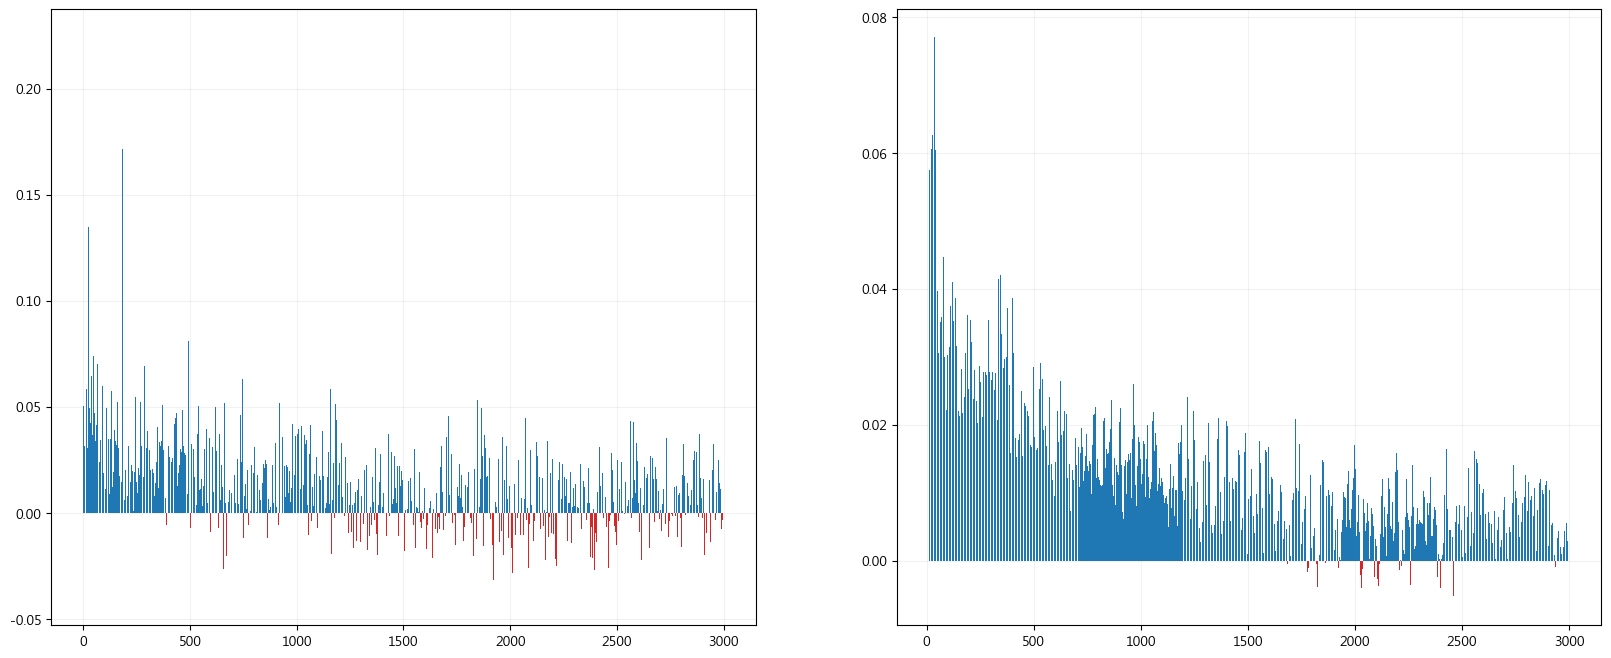

In [18]:
import matplotlib.pyplot as plt

plt.rc("font", family="Malgun Gothic")
plt.rc('axes', unicode_minus=False)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.1)

x = sorted(set(result["rfactor"]))
y = [result[result["rfactor"] == r]["수익률"].mean() for r in x]

return_by_rank = pd.DataFrame({"rfactor": x, "revenue": y})
print(return_by_rank.corr(method="pearson"))
print(return_by_rank.corr(method="kendall"))
print(return_by_rank.corr(method="spearman"))

print("전체 수익률 평균", result["수익률"].mean())

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(20)
fig.set_figheight(8)

ax1.grid(True)
ax1.bar(x, y, color=["tab:blue" if v > 0 else "tab:red" for v in y])

ax2.grid(True)
y_rolling = pd.Series(y).rolling(10).mean()
ax2.bar(x, y_rolling, color=["tab:blue" if v > 0 else "tab:red" for v in y_rolling])